# Classification modeling for MIT-BIH ECGs

## Executive Summary

Accurate classification of electrocardiogram (ECG) beats is a foundational task in automated cardiac monitoring and arrhythmia detection. In this project, we evaluate multiple supervised machine learning and deep learning approaches for multi-class ECG beat classification using beat-level waveform data derived from the MIT-BIH Arrhythmia Database.

The analysis focuses on five clinically meaningful beat classes and emphasizes robust performance under class imbalance, model interpretability, and generalization to unseen patients. Traditional machine learning models using engineered features are compared against convolutional neural networks (CNNs) trained directly on raw ECG waveforms.

Model performance is assessed using macro-averaged F1 score as the primary metric, supplemented by class-wise precision-recall analysis and receiver operating characteristic (ROC) curves. Confidence intervals are estimated via bootstrap resampling to quantify metric uncertainty.

These results provide practical guidance for selecting ECG classification models in clinical and real-world deployment settings.

## Problem Context and Clinical Motivation

Continuous ECG monitoring systems support early detection of potentially life-threatening arrhythmias. However:

- False negatives may delay treatment and cause patient harm
- False positives contribute to alarm fatigue, clinician distrust, and system abandonment
- Real-world ECG signals are noisy, heterogeneous, and subject to drift over time

This creates a high-stakes decision environment where model performance must be evaluated relative to operational constraints, not just classification accuracy.

Goal: Design and evaluate a beat-level ECG classification system that acknowledges clinical risk, operational tradeoffs, and deployment realities.

## Evaluation Strategy: Beyond Accuracy

Traditional metrics (accuracy, macro-F1) are insufficient in clinical monitoring contexts. This project emphasizes:

- Class-conditional recall, especially for clinically significant arrhythmias
- Sensitivity at fixed false-positive rates
- Precision at constrained alert volumes

A model with excellent overall accuracy may still be unusable if it:

- Misses rare but dangerous arrhythmias
- Produces excessive false alarms
- Is poorly calibrated and overconfident

In [1]:
from __future__ import annotations
from dataclasses import dataclass
from time import time
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, clone
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
)

from collections import Counter

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV

try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import SMOTE
    IMB_AVAILABLE = True
except Exception:
    IMB_AVAILABLE = False
    ImbPipeline = None
    SMOTE = None

try:
    import optuna
    from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution
    OPTUNA_AVAILABLE = True
except Exception:
    OPTUNA_AVAILABLE = False
    FloatDistribution = IntDistribution = CategoricalDistribution = object

import matplotlib.pyplot as plt


In [2]:
SCORING_DEFAULT = "f1_macro"
RANDOM_STATE = 42

@dataclass(frozen=True)
class ModelSpec:
    name: str
    pipeline: Any  # sklearn Pipeline or imblearn Pipeline
    param_grid: Dict[str, List[Any]]
    optuna_distributions: Optional[Dict[str, Any]] = None


def make_cv(cv_splits: int = 5, random_state: int = 42) -> StratifiedKFold:
    return StratifiedKFold(n_splits = cv_splits, shuffle = True, random_state = random_state)


def get_optuna_searchcv():
    """
    Optuna's sklearn integration may live in optuna-integration depending on version.
    We'll try both import paths.
    """
    try:
        from optuna_integration.sklearn import OptunaSearchCV  # type: ignore
        return OptunaSearchCV
    except Exception:
        try:
            from optuna.integration import OptunaSearchCV  # type: ignore
            return OptunaSearchCV
        except Exception:
            return None


def build_model_specs(use_smote: bool = False, random_state: int = 42) -> List[ModelSpec]:
    """
    Define the model families + search spaces.
    Edit this list to add/remove models.
    """
    if use_smote and not IMB_AVAILABLE:
        raise RuntimeError("use_smote=True requires `imbalanced-learn` (pip install imbalanced-learn).")

    Pipe = ImbPipeline if (use_smote and IMB_AVAILABLE) else Pipeline

    def maybe_smote_steps():
        return [("smote", SMOTE(random_state = random_state))] if use_smote else []

    specs: List[ModelSpec] = []

    # --- Logistic Regression ---
    specs.append(
        ModelSpec(
            name="logreg",
            pipeline=Pipe(
                steps=[
                    *maybe_smote_steps(),
                    ("scaler", StandardScaler()),
                    ("clf", LogisticRegression(
                        max_iter=5000,
                        class_weight="balanced",
                        random_state=random_state
                    )),
                ]
            ),
            param_grid={
                "clf__C": [0.01, 0.1, 1, 10, 50],
                "clf__solver": ["lbfgs"],
            },
            optuna_distributions=None if not OPTUNA_AVAILABLE else {
                "clf__C": FloatDistribution(1e-3, 1e2, log=True),
                "clf__solver": CategoricalDistribution(["lbfgs"]),
            },
        )
    )

    # --- Linear SVC (fast baseline) ---
    specs.append(
        ModelSpec(
            name="linear_svc",
            pipeline=Pipe(
                steps=[
                    *maybe_smote_steps(),
                    ("scaler", StandardScaler()),
                    ("clf", LinearSVC(class_weight="balanced", random_state=random_state)),
                ]
            ),
            param_grid={
                "clf__C": [0.01, 0.1, 1, 10, 50],
            },
            optuna_distributions=None if not OPTUNA_AVAILABLE else {
                "clf__C": FloatDistribution(1e-3, 1e2, log=True),
            },
        )
    )

    # --- RBF SVM ---
    specs.append(
        ModelSpec(
            name="svm_rbf",
            pipeline=Pipe(
                steps=[
                    *maybe_smote_steps(),
                    ("scaler", StandardScaler()),
                    ("clf", SVC(class_weight="balanced")),
                ]
            ),
            param_grid={
                "clf__C": [0.5, 1, 2, 5, 10],
                "clf__gamma": ["scale", 0.01, 0.1, 1],
                "clf__kernel": ["rbf"],
            },
            optuna_distributions=None if not OPTUNA_AVAILABLE else {
                "clf__C": FloatDistribution(1e-3, 1e2, log=True),
                "clf__gamma": FloatDistribution(1e-4, 1e0, log=True),
                "clf__kernel": CategoricalDistribution(["rbf"]),
            },
        )
    )

    # --- Random Forest ---
    '''
    specs.append(
        ModelSpec(
            name="rf",
            pipeline=Pipe(
                steps=[
                    *maybe_smote_steps(),
                    ("clf", RandomForestClassifier(
                        random_state=random_state,
                        n_jobs=-1,
                        class_weight="balanced"
                    )),
                ]
            ),
            param_grid={
                "clf__n_estimators": [300, 600],
                "clf__max_depth": [None, 10, 25],
                "clf__min_samples_split": [2, 5, 10],
                "clf__min_samples_leaf": [1, 2, 4],
                "clf__max_features": ["sqrt", "log2"],
            },
            optuna_distributions=None if not OPTUNA_AVAILABLE else {
                "clf__n_estimators": IntDistribution(200, 1000),
                "clf__max_depth": CategoricalDistribution([None, 8, 12, 18, 25, 35]),
                "clf__min_samples_split": IntDistribution(2, 20),
                "clf__min_samples_leaf": IntDistribution(1, 10),
                "clf__max_features": CategoricalDistribution(["sqrt", "log2"]),
            },
        )
    )
    '''

    # --- Extra Trees (often strong on noisy features) ---
    specs.append(
        ModelSpec(
            name="extra_trees",
            pipeline=Pipe(
                steps=[
                    *maybe_smote_steps(),
                    ("clf", ExtraTreesClassifier(
                        random_state=random_state,
                        n_jobs=-1,
                        class_weight="balanced"
                    )),
                ]
            ),
            param_grid={
                "clf__n_estimators": [500, 900],
                "clf__max_depth": [None, 10, 25],
                "clf__min_samples_leaf": [1, 2, 4],
                "clf__max_features": ["sqrt", "log2"],
            },
            optuna_distributions=None if not OPTUNA_AVAILABLE else {
                "clf__n_estimators": IntDistribution(200, 1200),
                "clf__max_depth": CategoricalDistribution([None, 8, 12, 18, 25, 35]),
                "clf__min_samples_leaf": IntDistribution(1, 10),
                "clf__max_features": CategoricalDistribution(["sqrt", "log2"]),
            },
        )
    )

    # --- HistGradientBoosting (fast, strong boosting in sklearn) ---
    specs.append(
        ModelSpec(
            name="hgb",
            pipeline=Pipe(
                steps=[
                    *maybe_smote_steps(),
                    ("clf", HistGradientBoostingClassifier(random_state=random_state)),
                ]
            ),
            param_grid={
                "clf__learning_rate": [0.03, 0.06, 0.1],
                "clf__max_depth": [None, 3, 5, 8],
                "clf__max_leaf_nodes": [15, 31, 63],
                "clf__min_samples_leaf": [10, 20, 50],
            },
            optuna_distributions=None if not OPTUNA_AVAILABLE else {
                "clf__learning_rate": FloatDistribution(1e-3, 3e-1, log=True),
                "clf__max_depth": CategoricalDistribution([None, 3, 5, 8, 12]),
                "clf__max_leaf_nodes": IntDistribution(15, 255),
                "clf__min_samples_leaf": IntDistribution(5, 100),
            },
        )
    )

    return specs


def run_multimodel_search(
    X_train,
    y_train,
    specs: List[ModelSpec],
    search: str = "random",  # "grid" | "random" | "halving_random" | "optuna"
    scoring: str = SCORING_DEFAULT,
    cv_splits: int = 5,
    n_jobs: int = -1,
    random_state: int = 42,
    verbose: int = 1,
    n_iter: int = 40,          # for RandomizedSearchCV
    optuna_trials: int = 60,   # for Optuna
    optuna_timeout: int | None = None,
) -> Tuple[pd.DataFrame, Any, BaseEstimator]:
    """
    Runs a hyperparameter search for each ModelSpec, returns:
      - leaderboard (pd.DataFrame)
      - best search object (GridSearchCV/RandomizedSearchCV/HalvingRandomSearchCV/Optuna study or OptunaSearchCV)
      - best fitted estimator
    """
    cv = make_cv(cv_splits=cv_splits, random_state=random_state)
    rows: List[Dict[str, Any]] = []

    best_score = -np.inf
    best_search_obj: Any = None
    best_estimator: Optional[BaseEstimator] = None

    OptunaSearchCV = get_optuna_searchcv() if search == "optuna" else None

    for spec in specs:
        t0 = time()

        if search == "grid":
            obj = GridSearchCV(
                estimator=spec.pipeline,
                param_grid=spec.param_grid,
                scoring=scoring,
                cv=cv,
                n_jobs=n_jobs,
                refit=True,
                return_train_score=True,
                verbose=verbose,
            )
            obj.fit(X_train, y_train)
            mean = float(obj.best_score_)
            std = float(obj.cv_results_["std_test_score"][obj.best_index_])
            best_params = obj.best_params_
            fitted_est = obj.best_estimator_
            search_label = "grid"

        elif search == "random":
            obj = RandomizedSearchCV(
                estimator=spec.pipeline,
                param_distributions=spec.param_grid,
                n_iter=n_iter,
                scoring=scoring,
                cv=cv,
                n_jobs=n_jobs,
                random_state=random_state,
                refit=True,
                return_train_score=True,
                verbose=verbose,
            )
            obj.fit(X_train, y_train)
            mean = float(obj.best_score_)
            std = float(obj.cv_results_["std_test_score"][obj.best_index_])
            best_params = obj.best_params_
            fitted_est = obj.best_estimator_
            search_label = "random"

        elif search == "halving_random":
            obj = HalvingRandomSearchCV(
                estimator=spec.pipeline,
                param_distributions=spec.param_grid,
                scoring=scoring,
                cv=cv,
                n_jobs=n_jobs,
                random_state=random_state,
                factor=3,
                refit=True,
                verbose=verbose,
            )
            obj.fit(X_train, y_train)
            mean = float(obj.best_score_)
            std = float(obj.cv_results_["std_test_score"][obj.best_index_]) if hasattr(obj, "cv_results_") else np.nan
            best_params = obj.best_params_
            fitted_est = obj.best_estimator_
            search_label = "halving_random"

        elif search == "optuna":
            if not OPTUNA_AVAILABLE:
                raise RuntimeError("Optuna not installed. `pip install optuna` (and optionally optuna-integration).")
            if spec.optuna_distributions is None:
                raise ValueError(f"Spec '{spec.name}' is missing optuna_distributions.")

            if OptunaSearchCV is not None:
                obj = OptunaSearchCV(
                    estimator=spec.pipeline,
                    param_distributions=spec.optuna_distributions,
                    n_trials=optuna_trials,
                    timeout=optuna_timeout,
                    scoring=scoring,
                    cv=cv,
                    n_jobs=n_jobs,
                    random_state=random_state,
                    refit=True,
                    verbose=verbose,
                )
                obj.fit(X_train, y_train)
                mean = float(obj.best_score_)
                std = float(obj.cv_results_["std_test_score"][obj.best_index_]) if hasattr(obj, "cv_results_") else np.nan
                best_params = obj.best_params_
                fitted_est = obj.best_estimator_
                search_label = "optuna_searchcv"
            else:
                # Fallback: pure optuna loop + cross_val_score
                def objective(trial: "optuna.Trial") -> float:
                    from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution

                    params = {}
                    for k, dist in spec.optuna_distributions.items():
                        if isinstance(dist, FloatDistribution):
                            params[k] = trial.suggest_float(k, dist.low, dist.high, log=dist.log)
                        elif isinstance(dist, IntDistribution):
                            params[k] = trial.suggest_int(k, dist.low, dist.high, log=dist.log, step=dist.step)
                        elif isinstance(dist, CategoricalDistribution):
                            params[k] = trial.suggest_categorical(k, dist.choices)
                        else:
                            raise TypeError(f"Unsupported distribution for {k}: {type(dist)}")

                    est = clone(spec.pipeline).set_params(**params)
                    score = cross_val_score(est, X_train, y_train, cv=cv, scoring=scoring, n_jobs=n_jobs).mean()
                    return float(score)

                study = optuna.create_study(direction="maximize")
                study.optimize(objective, n_trials=optuna_trials, timeout=optuna_timeout)

                best_params = study.best_params
                fitted_est = clone(spec.pipeline).set_params(**best_params)
                fitted_est.fit(X_train, y_train)

                obj = study
                mean = float(study.best_value)
                std = np.nan
                search_label = "optuna_fallback"

        else:
            raise ValueError(f"Unknown search='{search}'")

        elapsed = time() - t0

        rows.append(
            {
                "model": spec.name,
                "search": search_label,
                "best_cv_score": mean,
                "cv_std": std,
                "fit_seconds": elapsed,
                "best_params": best_params,
            }
        )

        if mean > best_score:
            best_score = mean
            best_search_obj = obj
            best_estimator = fitted_est

    leaderboard = pd.DataFrame(rows).sort_values("best_cv_score", ascending=False).reset_index(drop=True)
    assert best_estimator is not None
    return leaderboard, best_search_obj, best_estimator


def evaluate_on_test(best_estimator: BaseEstimator, X_test, y_test, target_names: Optional[List[str]] = None) -> None:
    y_pred = best_estimator.predict(X_test)
    print("Classification report:")
    print(classification_report(y_test, y_pred, target_names=target_names, digits=4))
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))


In [3]:
features_df = pd.read_csv("data/intermediate/features_df.csv")
features_df = features_df.drop(columns=["Unnamed: 0"])
features_df.head()

,instance_id,label,mean,median,std,var,iqr,rms,skew,kurtosis,...,wl2_energy,wl2_entropy,wl3_mean,wl3_std,wl3_energy,wl3_entropy,wl4_mean,wl4_std,wl4_energy,wl4_entropy
0,train_0,0.0,0.098419,0.061275,0.176073,0.031002,0.127451,0.201713,3.546201,13.625458,...,3.092462,2.784985,-0.001263,0.092072,0.440899,3.446628,-0.001050,0.022465,0.049062,4.520406
1,train_1,0.0,0.090010,0.054131,0.159722,0.025511,0.089744,0.183338,3.835006,16.261442,...,2.912508,3.188208,0.006891,0.099999,0.522455,3.918475,-0.001608,0.019330,0.036496,5.496482
2,train_2,0.0,0.062104,0.005405,0.138769,0.019257,0.058108,0.152032,4.324592,22.166908,...,2.404316,2.685323,0.003689,0.114485,0.682261,3.184270,0.004120,0.035490,0.123822,4.486136
3,train_3,0.0,0.084084,0.002762,0.160821,0.025863,0.110497,0.181476,3.477491,13.691748,...,1.381033,2.981231,0.007277,0.096107,0.483050,3.671304,0.002444,0.013934,0.019413,5.028199
4,train_4,0.0,0.116568,0.056338,0.186151,0.034652,0.145540,0.219637,3.109725,10.238894,...,1.897863,3.000491,-0.014618,0.056436,0.176734,4.423923,-0.000971,0.013421,0.017564,5.524272


In [4]:
# Get label counts
class_summary = (
    features_df["label"]
    .value_counts()
    .rename("n")
    .to_frame()
)

class_summary["prop"] = class_summary["n"] / class_summary["n"].sum()

class_summary


,n,prop
label,,
0.0,90589,0.827705
4.0,8039,0.073452
2.0,7236,0.066115
1.0,2779,0.025392
3.0,803,0.007337


In [5]:
# Define features and classes
X = features_df.drop(columns = ["instance_id","label"])
y = features_df["label"]

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    stratify = y,
    random_state = RANDOM_STATE
)

In [6]:
# Debate regarding use of SMOTE on training folds as they distort the original class balance.
# For this data set, would probably be fine as these waveforms were not collected in the wild but
# rather in a targeted lab-driven fashion. But will keep it off for now.
use_smote = False
specs = build_model_specs(use_smote=use_smote, random_state=42)

# use halving-random search for tradoff of grid and speed
search_backend = "halving_random"

leaderboard, best_search_obj, best_estimator = run_multimodel_search(
    X_train, y_train,
    specs=specs,
    search=search_backend,
    scoring="f1_macro",
    cv_splits=5,
    n_jobs=-1,
    random_state=42,
    verbose=1,
    n_iter=40,
    optuna_trials=30,
)

print("Top results:")
print(leaderboard.head(10))

print("\nBest estimator:")
print(best_estimator)

# Evaluate on held-out test set
evaluate_on_test(best_estimator, X_test, y_test, target_names=None)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 7
min_resources_: 50
max_resources_: 87556
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 5
n_resources: 50
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/zachquicksall/Documents/projects/ecg_beats/venv/lib/python3.14/site-packages/sklearn/model_selection/_search.py:324: UserWarning: The total space of parameters 5 is smaller than n_iter=1751. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 2
n_resources: 150
Fitting 5 folds for each of 2 candidates, totalling 10 fits
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 7
min_resources_: 50
max_resources_: 87556
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 5
n_resources: 50
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 1
n_candidates: 2
n_resources: 150
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/zachquicksall/Documents/projects/ecg_beats/venv/lib/python3.14/site-packages/sklearn/model_selection/_search.py:324: UserWarning: The total space of parameters 5 is smaller than n_iter=1751. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/zachquicksall/Documents/projects/ecg_beats/venv/lib/python3.14/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/zachquicksall/Documents/projects/ecg_beats/venv/lib/python3.14/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/zachquicksall/Documents/projects/ecg_beats/venv/lib/python3.14/site-packages/sklearn/svm/_base.py:1258: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/zachquicksall/Documents/projects/ecg_beats/venv/lib/python3.14/site-packag

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 7
min_resources_: 50
max_resources_: 87556
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 50
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 1
n_candidates: 7
n_resources: 150
Fitting 5 folds for each of 7 candidates, totalling 35 fits


/Users/zachquicksall/Documents/projects/ecg_beats/venv/lib/python3.14/site-packages/sklearn/model_selection/_search.py:324: UserWarning: The total space of parameters 20 is smaller than n_iter=1751. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 2
n_candidates: 3
n_resources: 450
Fitting 5 folds for each of 3 candidates, totalling 15 fits
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 7
min_resources_: 50
max_resources_: 87556
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 36
n_resources: 50
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/Users/zachquicksall/Documents/projects/ecg_beats/venv/lib/python3.14/site-packages/sklearn/model_selection/_search.py:324: UserWarning: The total space of parameters 36 is smaller than n_iter=1751. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 12
n_resources: 150
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 4
n_resources: 450
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 3
n_candidates: 2
n_resources: 1350
Fitting 5 folds for each of 2 candidates, totalling 10 fits
n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 7
min_resources_: 50
max_resources_: 87556
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 108
n_resources: 50
Fitting 5 folds for each of 108 candidates, totalling 540 fits


/Users/zachquicksall/Documents/projects/ecg_beats/venv/lib/python3.14/site-packages/sklearn/model_selection/_search.py:324: UserWarning: The total space of parameters 108 is smaller than n_iter=1751. Running 108 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------
iter: 1
n_candidates: 36
n_resources: 150
Fitting 5 folds for each of 36 candidates, totalling 180 fits
----------
iter: 2
n_candidates: 12
n_resources: 450
Fitting 5 folds for each of 12 candidates, totalling 60 fits
----------
iter: 3
n_candidates: 4
n_resources: 1350
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 4
n_candidates: 2
n_resources: 4050
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Top results:
         model          search  best_cv_score    cv_std  fit_seconds  \
0          hgb  halving_random       0.763179  0.042656    11.240695   
1  extra_trees  halving_random       0.739566  0.080987    21.304305   
2       logreg  halving_random       0.587630  0.157233     4.917147   
3      svm_rbf  halving_random       0.579141  0.074339    47.382377   
4   linear_svc  halving_random       0.545690  0.100501     3.953713   

                                         best_params  
0  {'clf__min_samples_leaf': 10, 'clf__max_l

## Model Leaderboard

In [7]:
def expand_params(leaderboard: pd.DataFrame, params_col: str = "best_params") -> pd.DataFrame:
    """
    Expands dict-like best_params into separate columns.
    """
    df = leaderboard.copy()
    params_df = pd.json_normalize(df[params_col])
    params_df.columns = [f"param::{c}" for c in params_df.columns]
    df = pd.concat([df.drop(columns=[params_col]), params_df], axis=1)
    return df


leaderboard_expanded = expand_params(leaderboard)
leaderboard_expanded


,model,search,best_cv_score,cv_std,fit_seconds,param::clf__min_samples_leaf,param::clf__max_leaf_nodes,param::clf__max_depth,param::clf__learning_rate,param::clf__n_estimators,param::clf__max_features,param::clf__solver,param::clf__C,param::clf__kernel,param::clf__gamma
0,hgb,halving_random,0.763179,0.042656,11.240695,10.0,63.0,3.0,0.1,NaN,NaN,NaN,NaN,NaN,NaN
1,extra_trees,halving_random,0.739566,0.080987,21.304305,4.0,NaN,NaN,NaN,500.0,sqrt,NaN,NaN,NaN,NaN
2,logreg,halving_random,0.587630,0.157233,4.917147,NaN,NaN,NaN,NaN,NaN,NaN,lbfgs,10.0,NaN,NaN
3,svm_rbf,halving_random,0.579141,0.074339,47.382377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,rbf,scale
4,linear_svc,halving_random,0.545690,0.100501,3.953713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN


## Top Models by CV Score

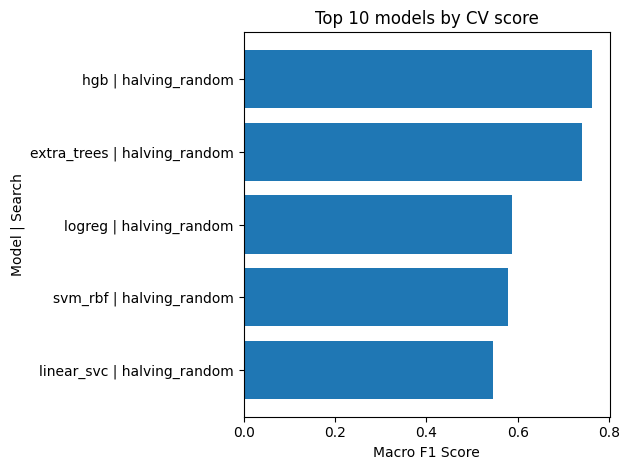

In [8]:
def plot_leaderboard(leaderboard: pd.DataFrame, top_n: int = 10) -> None:
    df = leaderboard.head(top_n).copy()
    df = df.iloc[::-1]  # reverse so best is on top in a horizontal bar

    plt.figure()
    plt.barh(df["model"] + " | " + df["search"], df["best_cv_score"])
    plt.xlabel("Macro F1 Score")
    plt.ylabel("Model | Search")
    plt.title(f"Top {top_n} models by CV score")
    plt.tight_layout()
    plt.show()


plot_leaderboard(leaderboard, top_n=10)


## Models by Fitting Time

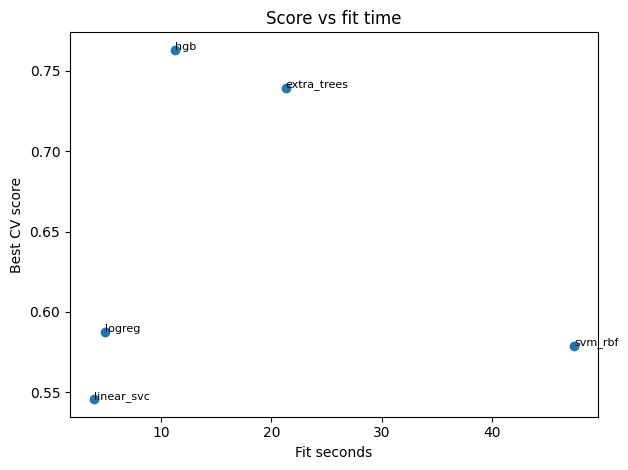

In [9]:
def plot_score_vs_time(leaderboard: pd.DataFrame) -> None:
    plt.figure()
    plt.scatter(leaderboard["fit_seconds"], leaderboard["best_cv_score"])
    for _, r in leaderboard.iterrows():
        plt.text(r["fit_seconds"], r["best_cv_score"], str(r["model"]), fontsize=8)

    plt.xlabel("Fit seconds")
    plt.ylabel("Best CV score")
    plt.title("Score vs fit time")
    plt.tight_layout()
    plt.show()


plot_score_vs_time(leaderboard)


## Confusion Matrix

Due to high class imbalance, the majority class is saturating the color scale, making this plot rather uninsightful. Will use class-specific ROC curves instead.

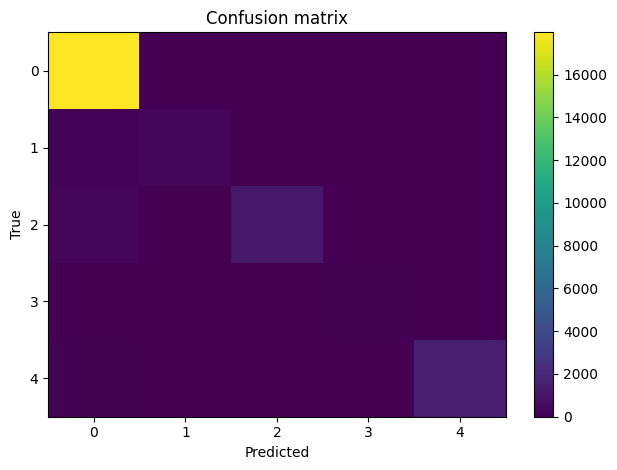

In [10]:
def plot_confusion_matrix(best_estimator: BaseEstimator, X_test, y_test) -> None:
    cm = confusion_matrix(y_test, best_estimator.predict(X_test))
    plt.figure()
    plt.imshow(cm, aspect="auto")
    plt.title("Confusion matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


plot_confusion_matrix(best_estimator, X_test, y_test)


## OvR ROC Curves

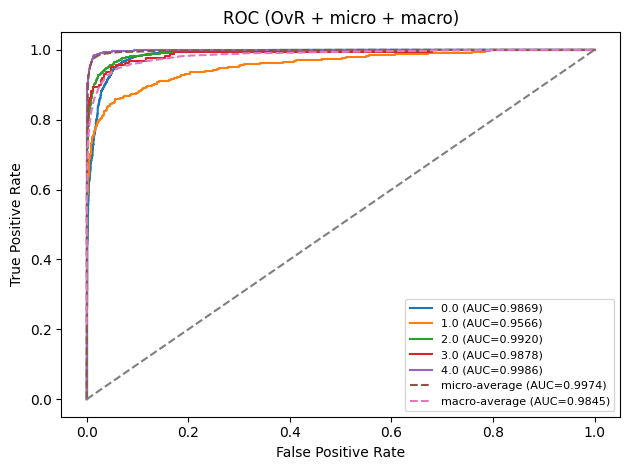

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def _get_scores(estimator, X):
    """
    Returns per-class scores for ROC:
      - predict_proba if available
      - else decision_function if available
    Output shape:
      binary: (n_samples,) or (n_samples, 2)
      multiclass: (n_samples, n_classes)
    """
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)

    if hasattr(estimator, "decision_function"):
        return estimator.decision_function(X)

    raise ValueError(
        "Estimator has neither predict_proba nor decision_function. "
        "Use a model that supports scores, or wrap with CalibratedClassifierCV."
    )

def plot_roc_curves(
    estimator,
    X_test,
    y_test,
    class_names=None,
    title="ROC Curves",
    show_micro=True,
    show_macro=True,
):
    """
    Plots ROC curves for:
      - Binary: single ROC
      - Multiclass: One-vs-rest per class + micro-average + macro-average (optional)
    """
    scores = _get_scores(estimator, X_test)

    y = np.asarray(y_test)
    classes = np.unique(y)
    n_classes = len(classes)

    if class_names is None:
        class_names = [str(c) for c in classes]

    plt.figure()
    plt.title(title)

    # -----------------
    # Binary case
    # -----------------
    if n_classes == 2:
        # Convert scores to 1D positive-class score
        if scores.ndim == 2:
            pos_class = classes[1]
            if hasattr(estimator, "classes_"):
                pos_idx = int(np.where(estimator.classes_ == pos_class)[0][0])
            else:
                pos_idx = 1
            y_score = scores[:, pos_idx]
        else:
            y_score = scores

        y_true = (y == classes[1]).astype(int)

        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.4f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()
        return

    # -----------------
    # Multiclass case (OvR)
    # -----------------
    y_bin = label_binarize(y, classes=classes)  # (n_samples, n_classes)

    if scores.ndim != 2 or scores.shape[1] != n_classes:
        raise ValueError(
            f"Expected scores of shape (n_samples, n_classes) for multiclass ROC. "
            f"Got {getattr(scores, 'shape', None)}. "
            "If you're using a pipeline, ensure the final estimator supports predict_proba/decision_function."
        )

    fpr_dict = {}
    tpr_dict = {}
    auc_dict = {}

    for i in range(n_classes):
        fpr_i, tpr_i, _ = roc_curve(y_bin[:, i], scores[:, i])
        fpr_dict[i] = fpr_i
        tpr_dict[i] = tpr_i
        auc_dict[i] = auc(fpr_i, tpr_i)

        plt.plot(fpr_i, tpr_i, label=f"{class_names[i]} (AUC={auc_dict[i]:.4f})")

    # ---- Micro-average ----
    if show_micro:
        fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), scores.ravel())
        auc_micro = auc(fpr_micro, tpr_micro)
        plt.plot(
            fpr_micro, tpr_micro,
            linestyle="--",
            label=f"micro-average (AUC={auc_micro:.4f})"
        )

    # ---- Macro-average ----
    if show_macro:
        
        all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(n_classes)]))
        mean_tpr = np.zeros_like(all_fpr)

        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
        mean_tpr /= n_classes

        auc_macro = auc(all_fpr, mean_tpr)
        
        plt.plot(
            all_fpr, mean_tpr,
            linestyle="--",
            label=f"macro-average (AUC={auc_macro:.4f})"
        )

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.show()

plot_roc_curves(best_estimator, X_test, y_test, class_names=None, title="ROC (OvR + micro + macro)")

## Varible Importance

In [12]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    best_estimator,
    X_test,
    y_test,
    n_repeats = 25,
    random_state = 42,
    scoring = "f1_macro",
    n_jobs = -1,
)

feature_names = (
    X_test.columns
    if hasattr(X_test, "columns")
    else [f"x{i}" for i in range(X_test.shape[1])]
)

importances = pd.DataFrame(
    {
        "feature": feature_names,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

importances.head(15)


/Users/zachquicksall/Documents/projects/ecg_beats/venv/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,feature,importance_mean,importance_std
25,spec_spread,0.079246,0.004453
38,wl1_entropy,0.072313,0.003374
29,bp_15_40,0.063266,0.003841
16,pos_slope_ratio,0.058743,0.003885
0,mean,0.040229,0.003990
15,std_slope,0.036897,0.002941
8,signal_length,0.034920,0.004331
1,median,0.034042,0.003370
32,wl0_std,0.030447,0.002668
34,wl0_entropy,0.030321,0.003678


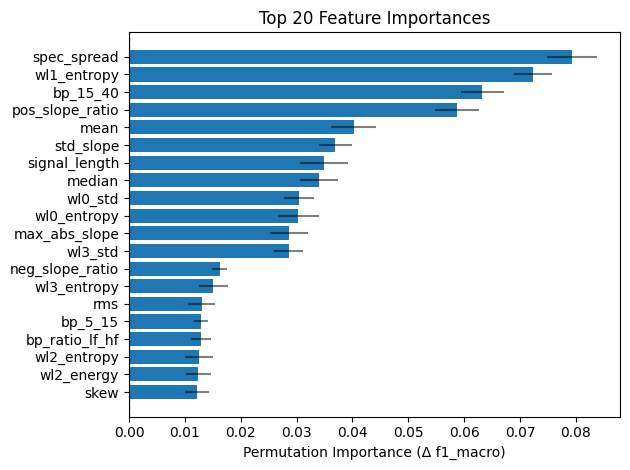

In [13]:
def plot_permutation_importance(df, top_n = 20):

    df = df.head(top_n).iloc[::-1]

    plt.figure()
    plt.barh(
        df["feature"],
        df["importance_mean"],
        xerr=df["importance_std"],
        error_kw=dict(alpha=0.5),
    )
    plt.axvline(0, linestyle="--", linewidth=1)
    plt.xlabel("Permutation Importance (Δ f1_macro)")
    plt.title(f"Top {top_n} Feature Importances")
    plt.tight_layout()
    plt.show()

plot_permutation_importance(importances, top_n = 20)

Top-features shown for illustration. Instead of digging into feature utility, we will focus our efforts on properly evaluating model performance in a context-aware maner (i.e. utility in the actual clinic).

## Decision-aware evaluation

### Class-conditional performance metrics

In [14]:
def per_class_metrics(y_true, y_pred):
    
    labels = np.array(sorted(set(y_true) | set(y_pred)))

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred,
        labels=labels,
        average=None,
        zero_division=0
    )

    df = pd.DataFrame({
        "class_id": labels,
        "support": support,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }).sort_values(["support"], ascending=False)

    return df

# Generate model predictions
y_pred = best_estimator.predict(X_test)
y_prob = best_estimator.predict_proba(X_test)

# Compute per-class metrics
df_metrics = per_class_metrics(y_test, y_pred)

# View
df_metrics.head()

,class_id,support,precision,recall,f1
0,0.0,18118,0.969419,0.992052,0.980605
4,4.0,1608,0.964193,0.921020,0.942112
2,2.0,1447,0.909021,0.814789,0.859329
1,1.0,556,0.884817,0.607914,0.720682
3,3.0,161,0.850746,0.708075,0.772881


Model performance is strongly influenced by class prevalence. Classes with high support (e.g., Class 0) exhibit the strongest and most stable performance, while rarer classes show increased variability—particularly in recall. This pattern is expected in imbalanced datasets and highlights the importance of evaluating performance beyond aggregate metrics.

Class 1 presents a clear challenge for the model. Although precision is relatively strong (0.88), recall falls sharply to ~0.61, yielding an F1-score of ~0.72. This asymmetry implies the model is conservative in assigning this label: when it predicts Class 1 it is usually correct, but it frequently fails to detect all true instances. From a clinical standpoint, this pattern may be concerning if Class 1 corresponds to a clinically meaningful abnormality, as missed detections may be more consequential than false positives.

Class 3 has the smallest support (161 beats) and exhibits the most uncertainty. While precision (0.85) and recall (0.71) are not catastrophic, they are noticeably lower than for more common classes. The modest F1-score (~0.77) likely reflects both limited training data and higher intra-class variability. This underscores the difficulty of learning robust decision boundaries for rare arrhythmias without targeted mitigation strategies.

In summary, the model performs exceptionally well on common beat types and reasonably well on moderately frequent classes, but struggles with recall for rarer categories. These results justify the use of macro-averaged metrics elsewhere in the analysis, as they prevent dominant classes from obscuring weaknesses in minority classes. Future improvements may involve targeted data augmentation, cost-sensitive learning, or hierarchical classification approaches to better capture rare but clinically important beats.

### Class-normalized confusion matrix

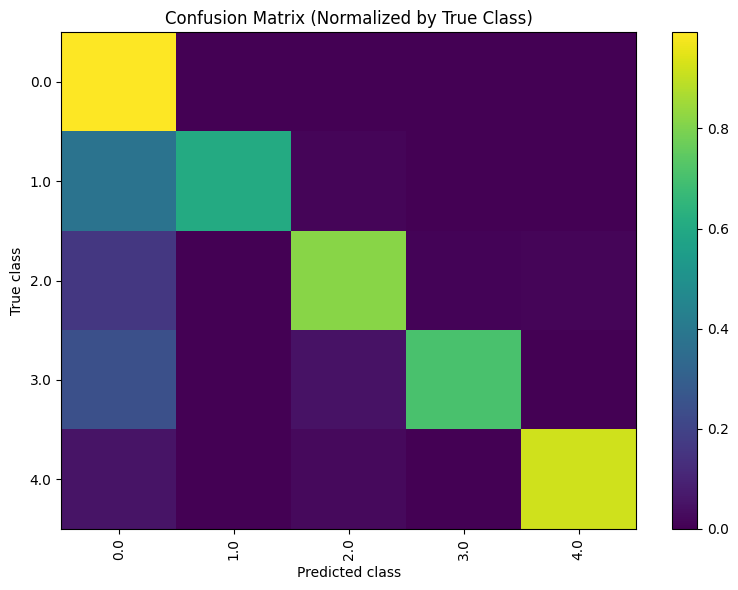

In [15]:
labels = np.array(sorted(set(y_test) | set(y_pred)))
cm = confusion_matrix(y_test, y_pred, labels=labels, normalize="true")

plt.figure(figsize=(8, 6))
plt.imshow(cm, aspect="auto")
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=90)
plt.yticks(range(len(labels)), labels)
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion Matrix (Normalized by True Class)")
plt.tight_layout()
plt.show()

When normalized within their true category, the confusion matrix becomes more useful for identifying weak points. The most obvious of which is the tendency for the model to miss-classify abnormal ECGs as normal. This makes sense given the massive bias in favor of normal ECG waveforms.

### Sensitivity at fixed FPR

> “If I only allow X% false alarms for class k, how many true class-k beats do I detect?”

In [16]:
def tpr_at_fpr(y_true_bin, score, fpr_targets=(0.001, 0.005, 0.01, 0.02)):
    fpr, tpr, _ = roc_curve(y_true_bin, score)
    out = {}
    for ft in fpr_targets:
        m = fpr <= ft
        out[ft] = float(tpr[m].max()) if np.any(m) else 0.0
    return out

def pick_candidate_classes(y_true, top_n=5):
    counts = Counter(np.asarray(y_true).tolist())
    majority = counts.most_common(1)[0][0]
    candidates = [cid for cid, _ in counts.most_common(top_n + 1) if cid != majority]
    return majority, candidates, counts

def class_tpr_at_fpr_table(y_true, proba, class_ids, classes_in_proba, fpr_targets=(0.001, 0.005, 0.01, 0.02)):
    y_true = np.asarray(y_true)
    P = np.asarray(proba)

    col_index = {label: i for i, label in enumerate(classes_in_proba)}

    rows = []
    for cid in class_ids:
        if cid not in col_index:
            continue  # class not in proba columns
        y_bin = (y_true == cid).astype(int)
        score = P[:, col_index[cid]]
        out = tpr_at_fpr(y_bin, score, fpr_targets=fpr_targets)
        row = {"class_id": cid, "support": int(y_bin.sum())}
        row.update({f"TPR@FPR={ft:.3%}": out[ft] for ft in fpr_targets})
        rows.append(row)

    return pd.DataFrame(rows).sort_values("support", ascending=False)

majority_id, candidate_ids, counts = pick_candidate_classes(y_test, top_n=5)

classes_in_proba = best_estimator.classes_

df_tpr = class_tpr_at_fpr_table(
    y_true=y_test,
    proba=y_prob,
    class_ids=candidate_ids,
    classes_in_proba=classes_in_proba,
    fpr_targets=(0.001, 0.005, 0.01, 0.02),
)

df_tpr

,class_id,support,TPR@FPR=0.100%,TPR@FPR=0.500%,TPR@FPR=1.000%,TPR@FPR=2.000%
0,4.0,1608,0.891791,0.941542,0.965796,0.986940
1,2.0,1447,0.668970,0.814098,0.865930,0.914997
2,1.0,556,0.543165,0.674460,0.741007,0.785971
3,3.0,161,0.701863,0.850932,0.881988,0.894410


The table above reports true positive rates (TPR) evaluated at increasingly permissive false positive rate (FPR) thresholds. This analysis characterizes how model sensitivity evolves as the decision threshold is relaxed, which is particularly relevant for clinical screening and monitoring applications where acceptable false alarm rates are often tightly constrained.

At very low FPRs (≤0.1%), the classifier is operating in a highly conservative regime. Performance at this operating point reflects the model’s ability to identify the most unambiguous examples of each class while producing almost no false alarms.
As expected, sensitivity varies substantially across classes, with rarer or morphologically ambiguous beats exhibiting lower TPR under strict constraints.

Across all classes, sensitivity improves monotonically as false positive tolerance increases, but the rate of improvement differs markedly by class. Classes with strong early TPRs are well suited for high-specificity screening scenarios, while weaker classes may require threshold adjustments or downstream confirmation steps.

These results emphasize the importance of operating-point–aware evaluation rather than relying solely on threshold-free metrics such as ROC-AUC. In practical deployment, different beat types may warrant different sensitivity–specificity trade-offs depending on their clinical significance and downstream costs.

### Precision@K and Recall@K

>“If I am only allowed to raise K alerts, how useful are they?”

1. Define “normal-like” beats:
    - I.e. majority class (0)
1. Everything else = alert-worthy
1. Rank beats by “abnormality confidence”
1. Take the top-K most confident beats
1. Measure:
    - Precision@K → how many alerts are real abnormalities
    - Recall@K → how many true abnormal beats we captured

In [17]:
def alert_budget_metrics(
    y_true,
    y_prob,
    normal_label=0,
    classes_in_proba=None,
    budgets=(0.001, 0.002, 0.005, 0.01),
):
    """
    Compute Precision@K and Recall@K for an alerting proxy:
      - normal_label is treated as "normal-like"
      - all other labels treated as "abnormal"
      - alert score = 1 - P(normal_label)

    Parameters
    ----------
    y_true : array-like, shape (N,)
        True integer labels.
    y_prob : array-like, shape (N, C)
        Predicted probabilities (e.g., from predict_proba).
    normal_label : int/float
        Label to treat as normal-like (default 0).
    classes_in_proba : array-like, shape (C,), optional
        Labels corresponding to each probability column (e.g., best_estimator.classes_).
        If None, assumes columns correspond to labels 0..C-1.
    budgets : iterable of float
        Alert budgets as fractions of samples to alert on (e.g., 0.005 = top 0.5%).

    Returns
    -------
    pd.DataFrame
        Columns: budget_frac, K, precision_at_k, recall_at_k, alerts_true_abnormal, total_abnormal
    """
    y = np.asarray(y_true)
    P = np.asarray(y_prob)

    if P.ndim != 2:
        raise ValueError(f"y_prob must be 2D (N, C). Got shape {P.shape}.")

    n = len(y)
    if P.shape[0] != n:
        raise ValueError(f"y_true and y_prob row mismatch: {n} vs {P.shape[0]}")

    # Map normal_label -> column index
    if classes_in_proba is None:
        # assumes label == column index
        normal_col = int(normal_label)
        if not (0 <= normal_col < P.shape[1]):
            raise ValueError(
                f"normal_label={normal_label} implies column {normal_col}, "
                f"but y_prob has {P.shape[1]} columns. Provide classes_in_proba."
            )
    else:
        classes_in_proba = np.asarray(classes_in_proba)
        col_index = {lbl: i for i, lbl in enumerate(classes_in_proba)}
        if normal_label not in col_index:
            raise ValueError(
                f"normal_label={normal_label} not found in classes_in_proba={classes_in_proba}"
            )
        normal_col = col_index[normal_label]

    # Alert score and ground truth abnormal indicator
    p_alert = 1.0 - P[:, normal_col]
    y_abn = (y != normal_label).astype(int)

    total_abnormal = int(y_abn.sum())

    # Pre-sort once for efficiency
    order = np.argsort(-p_alert)

    rows = []
    for b in budgets:
        if not (0 < b <= 1):
            raise ValueError(f"Budget fractions must be in (0,1]. Got {b}")

        K = max(1, int(round(b * n)))
        idx = order[:K]

        alerts_true_abnormal = int(y_abn[idx].sum())
        precision = alerts_true_abnormal / K
        recall = alerts_true_abnormal / max(1, total_abnormal)

        rows.append({
            "budget_frac": float(b),
            "K": int(K),
            "precision_at_k": float(precision),
            "recall_at_k": float(recall),
            "alerts_true_abnormal": alerts_true_abnormal,
            "total_abnormal": total_abnormal,
        })

    return pd.DataFrame(rows).sort_values("budget_frac")

import matplotlib.pyplot as plt

def plot_alert_budget_tradeoff(df, title_prefix="Alert-budget tradeoff"):
    """
    Plot Precision@K and Recall@K vs alert budget fraction.

    Parameters
    ----------
    df : pd.DataFrame
        Output of alert_budget_metrics().
    title_prefix : str
        Prefix for plot titles.
    """
    # Precision plot
    plt.figure(figsize=(7, 4))
    plt.plot(df["budget_frac"], df["precision_at_k"], marker="o")
    plt.xlabel("Alert budget (fraction of beats alerted)")
    plt.ylabel("Precision@K")
    plt.title(f"{title_prefix}: Precision vs Budget")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Recall plot
    plt.figure(figsize=(7, 4))
    plt.plot(df["budget_frac"], df["recall_at_k"], marker="o")
    plt.xlabel("Alert budget (fraction of beats alerted)")
    plt.ylabel("Recall@K")
    plt.title(f"{title_prefix}: Recall vs Budget")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    plt.tight_layout()
    plt.show()



In [18]:
df_budget = alert_budget_metrics(
    y_true = y_test,
    y_prob = y_prob,
    normal_label = 0.0,
    classes_in_proba = best_estimator.classes_,
    budgets = (0.001, 0.002, 0.005, 0.01, 0.02)
)

df_budget

,budget_frac,K,precision_at_k,recall_at_k,alerts_true_abnormal,total_abnormal
0,0.001,22,1.000000,0.005832,22,3772
1,0.002,44,1.000000,0.011665,44,3772
2,0.005,109,1.000000,0.028897,109,3772
3,0.010,219,1.000000,0.058059,219,3772
4,0.020,438,0.997717,0.115854,437,3772


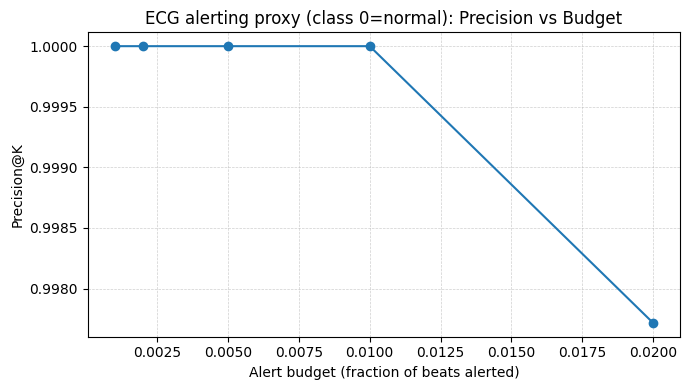

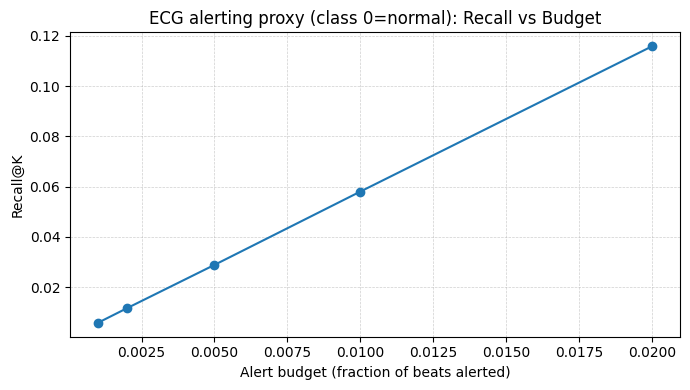

In [19]:
plot_alert_budget_tradeoff(df_budget, title_prefix="ECG alerting proxy (class 0=normal)")

The above table and graphs summarize model performance under an alert budget framework, where only the top-K highest-confidence predictions are surfaced for review. The budget fraction represents the proportion of all beats that can trigger alerts, simulating realistic operational constraints such as clinician attention, monitoring bandwidth, or downstream review costs.

At extremely low alert budgets (0.1%–1.0%), the model achieves perfect precision (1.00). Every alert raised at these operating points corresponds to a true abnormal beat, indicating exceptional confidence calibration at the top end of the score distribution. This behavior is critical in high-stakes settings where false alarms are unacceptable. Even at a 2.0% alert budget, precision remains exceptionally high (0.998), with only a single false alert among 438 surfaced beats. This demonstrates that expanding alert capacity modestly does not meaningfully degrade reliability.

Recall increases approximately linearly as the alert budget expands, rising from 0.6% at a 0.1% budget to 11.6% at a 2.0% budget. This pattern reflects the unavoidable trade-off imposed by capacity constraints: while only a small fraction of total abnormal beats can be captured under tight budgets, those that are captured are identified with near-perfect accuracy.
Importantly, even at the most permissive operating point shown, fewer than 12% of all abnormal beats (437 of 3,772) are surfaced. This underscores that alert budgeting is not a replacement for full classification, but rather a triage mechanism that prioritizes the most salient events.

These results suggest that the model is well suited for tiered alerting strategies. Under severe constraints, the system can reliably surface only the most obvious abnormalities, minimizing alarm fatigue. As capacity increases, additional—but still high-confidence—events can be included without materially increasing false positives. Such behavior is particularly valuable in continuous monitoring scenarios (e.g., ambulatory ECG or long-term telemetry), where clinicians may only be able to review a limited subset of events. The near-perfect precision at low budgets indicates that the model’s confidence scores are meaningfully ordered and clinically interpretable.
